In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import datetime

from scipy.stats import shapiro
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna

%matplotlib inline

# ExploratoryDataAnalysis

In [4]:
# загрузим данные трейна
df = pd.read_csv('train.csv')

In [5]:
# имеются пропущенные значения: 3 скрытых колонки, First_default_date, Successful_deals_count, Region
# колонки с датами имеют тип object
# df.Default - таргет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Deal_id                 3168 non-null   int64  
 1   Deal_date               3168 non-null   object 
 2   First_deal_date         3168 non-null   object 
 3   Secret_dwarf_info_1     535 non-null    float64
 4   Secret_dwarf_info_2     535 non-null    float64
 5   Secret_dwarf_info_3     535 non-null    float64
 6   First_default_date      535 non-null    object 
 7   Successful_deals_count  3154 non-null   float64
 8   Region                  3161 non-null   object 
 9   Tavern                  3168 non-null   int64  
 10  Hashed_deal_detail_1    3168 non-null   float64
 11  Hashed_deal_detail_2    3168 non-null   int64  
 12  Hashed_deal_detail_3    3168 non-null   int64  
 13  Hashed_deal_detail_4    3168 non-null   float64
 14  Hashed_deal_detail_5    3168 non-null   

In [6]:
df.head(3)

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0


In [7]:
# задача бинарной классификации с диспропорцией классов
df.Default.value_counts()

0    2817
1     351
Name: Default, dtype: int64

Итого имеется три типа данных:  
    1. **Числовые**  
    - Deal_id      
    - Secret_dwarf_info 1 - 3     
    - Successful_deals_count  
    - Tavern  
    - Hashed_deal_detail 1 - 6  
    - Age  
    2. **Категориальные**  
    - Region  
    - Gender  
    3. **Временные**  
    - Deal_date  
    - First_deal_date  
    - First_default_date  

<AxesSubplot:>

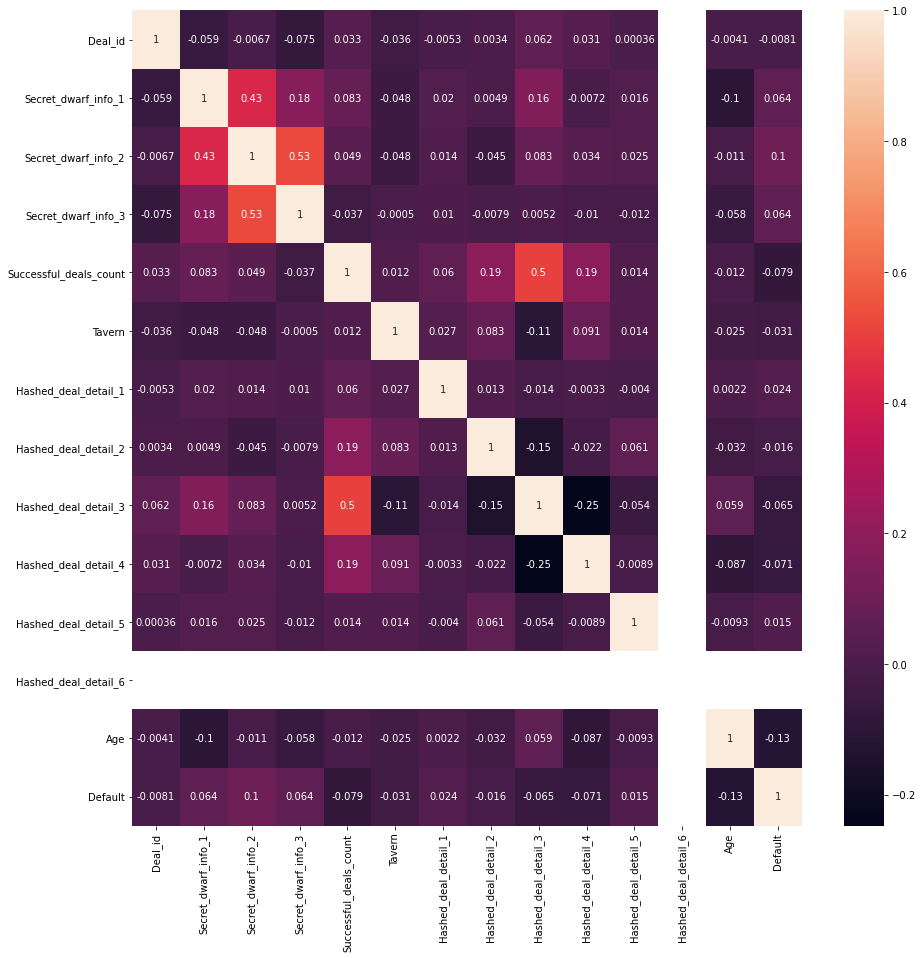

In [18]:
# сильных корреляций между фичами не наблюдается
figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True)

### Изучим числовые фичи

<AxesSubplot:>

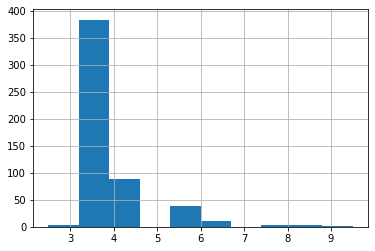

In [6]:
df.Secret_dwarf_info_1.hist()

<AxesSubplot:>

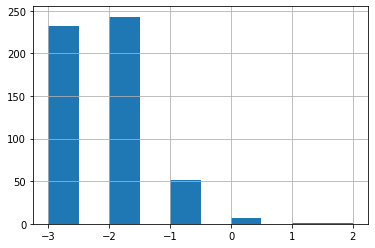

In [7]:
df.Secret_dwarf_info_2.hist()

<AxesSubplot:>

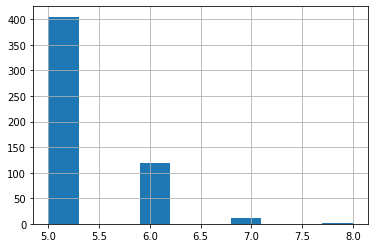

In [8]:
df.Secret_dwarf_info_3.hist()

Секретные признаки выглядят как числовые дискретные (но возможно их рассмотреть и как порядковые)

<AxesSubplot:>

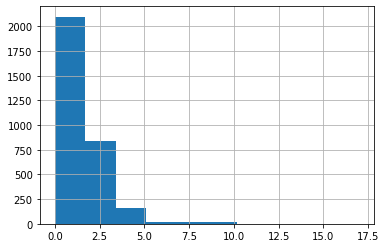

In [22]:
# распределение числа оплаченных заказов
# у большинства юзеров значение фичи = 0
df.Successful_deals_count.hist()

In [72]:
print(shapiro(df.Secret_dwarf_info_1[df.Secret_dwarf_info_1.notna()]))
print(shapiro(df.Secret_dwarf_info_2[df.Secret_dwarf_info_2.notna()]))
print(shapiro(df.Secret_dwarf_info_3[df.Secret_dwarf_info_3.notna()]))
print(shapiro(df.Successful_deals_count[df.Successful_deals_count.notna()]))

ShapiroResult(statistic=0.59234219789505, pvalue=1.5330122332527512e-33)
ShapiroResult(statistic=0.7682059407234192, pvalue=8.633050309193783e-27)
ShapiroResult(statistic=0.5588204860687256, pvalue=1.5028699867037754e-34)
ShapiroResult(statistic=0.6698945760726929, pvalue=0.0)


Пропущенные значения у рассмотренных признаков - трех секретных и Successful_deals_count - предлагается заменить на моды их распределений, поскольку их распределения отличаются от нормального

<AxesSubplot:>

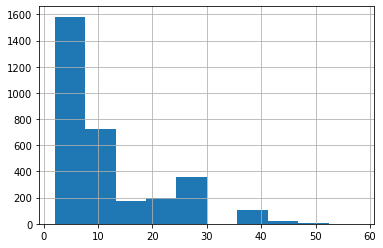

In [6]:
df.Tavern.hist()

In [21]:
# распределение отлично от нормального, значения от 2 до 58
shapiro(df.Tavern)

ShapiroResult(statistic=0.7422202825546265, pvalue=0.0)

In [27]:
# посмотрим на значения хэшированных признаков
hash_cols = ['Hashed_deal_detail_1', 'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4',
       'Hashed_deal_detail_5', 'Hashed_deal_detail_6']
for col in hash_cols:
    print(f'{df[col].nunique()} values in {col} column')

7 values in Hashed_deal_detail_1 column
23 values in Hashed_deal_detail_2 column
23 values in Hashed_deal_detail_3 column
21 values in Hashed_deal_detail_4 column
7 values in Hashed_deal_detail_5 column
1 values in Hashed_deal_detail_6 column


Последнюю колонку можно попробовать удалить, остальные - рассмотреть как числовой признак / категориальный признак

<AxesSubplot:>

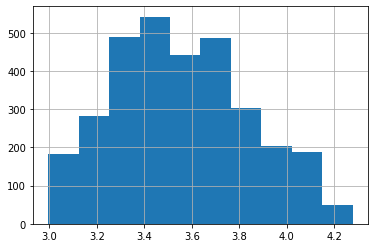

In [28]:
# можно попробовать прологарифмировать возраст юзеров
np.log(df.Age).hist()

In [20]:
# фича Region - категориальная
df.Region.value_counts()

Tavern_district_3    1204
Tavern_district_6     478
Tavern_district_2     448
Tavern_district_4     364
Tavern_district_1     240
Tavern_district_0     213
Tavern_district_5     160
Tavern_district_7      54
Name: Region, dtype: int64

In [31]:
# есть всего 535 дат первого дефолта по более чем 3000 юзерам
df.First_default_date.dropna().min(), df.First_default_date.dropna().max(), df.First_default_date.dropna().count()

('2015-05-01', '2016-09-13', 535)

# FeatureEngineering  


- **заменим пропущенные значения** (*First_default_date* - какой-нибудь **датой**, явно отличающейся от рассматриваемого периода, например за год до наблюдений (чтобы по этой фиче объекты точно отличались друг от друга), остальные признаки *Region, Secret_dwarf_info_1, Secret_dwarf_info_2, Secret_dwarf_info_3, Successful_deals_count* на **моды** соответствующих распределений)  
- **добавим временные периоды** по всем соответствующим фичам (время от первого заказа до нынешнего *First_deal_date - Deal_date* / время от первого дефолта до нынешнего заказа *First_default_date - Deal_date* / время от первого заказа до первого дефолта *First_default_date - First_deal_date*) и **удалим** *первоначальные даты*    
- **добавим стандартные отклонения** *секретных и хэшированных* признаков  
- **залогируем** возраст *np.log(Age)*  
- **стандартизуем** *df.Tavern*  
- **удалим** признак с константным значением *Hashed_deal_detail_6* и неинформативный айдишник *Deal_id*  

In [78]:
# класс для препроцессинга колонок с отсутствующими значениями
class DataTransformNull(BaseEstimator, TransformerMixin):
    
    def __init__(self, mode_cols, date_cols):
        self.mode_cols = mode_cols
        self.date_cols = date_cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for col in self.mode_cols:
            X[col] = X[col].fillna(X[col].mode()[0])
        min_date = pd.to_datetime(X[self.date_cols[-1]]).dropna().min() - datetime.timedelta(days = 365)
        X[self.date_cols[-1]] = X[self.date_cols[-1]].fillna(min_date)
        return X
    
# класс для препроцессинга временных фичей
class DateTransform(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_cols):
        self.date_cols = date_cols

    def fit(self, X, y = None):    
        return self
    
    def transform(self, X, y = None):
        for col in self.date_cols:
            X[col] = X[col].apply(pd.to_datetime)
            X[col + '_year'] = X[col].dt.year
            X[col + '_month'] = X[col].dt.month
            X[col + '_day'] = X[col].dt.day
        X['default_period_from_first_deal'] = (pd.to_datetime(X[self.date_cols[-1]]) - pd.to_datetime(X[self.date_cols[1]])).dt.days.fillna(0)
        X['deal_from_default'] = (pd.to_datetime(X[self.date_cols[0]]) - pd.to_datetime(X[self.date_cols[-1]])).dt.days.fillna(0)
        X['deal_from_first_deal'] = (pd.to_datetime(X[self.date_cols[0]]) - pd.to_datetime(X[self.date_cols[1]])).dt.days.fillna(0)
        return X

# логируем
class NumLog(BaseEstimator, TransformerMixin):
    
    def __init__(self, log_cols):
        self.log_cols = log_cols
        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y = None):
        for col in self.log_cols:
            X[col] = np.log(X[col])
        return X
    
# стандартизуем
class Scaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler_cols):
        self.scaler_cols = scaler_cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        scaler = StandardScaler()
        for col in self.scaler_cols:
            X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        return X
    
# добавим вариативность признаков
class StdCol(BaseEstimator, TransformerMixin):
    
    def __init__(self, std_cols):
        self.std_cols = std_cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X[self.std_cols[0] + '_std'] = X[self.std_cols].std(axis = 1)
        
        return X
    
# удалим лишнее
class DelCols(BaseEstimator, TransformerMixin):
    
    def __init__(self, del_cols):
        self.del_cols = del_cols
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X = X.drop(columns = self.del_cols, axis = 1)
        return X

In [79]:
mode_cols = ['Region', 'Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3', 'Successful_deals_count']
date_cols = ['Deal_date', 'First_deal_date', 'First_default_date']
log_cols = ['Age']
scaler_cols = ['Tavern']
std_cols = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3']
std_cols1 = ['Hashed_deal_detail_1', 'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Hashed_deal_detail_5']
del_cols = ['Deal_id', 'Hashed_deal_detail_6', 'Deal_date', 'First_deal_date', 'First_default_date']

df = pd.read_csv('train.csv')

pipe = Pipeline([('null_cols', DataTransformNull(mode_cols, date_cols)),
                 ('date', DateTransform(date_cols)),
                 ('num_log', NumLog(log_cols)), 
                 ('scaler', Scaler(scaler_cols)),
                 ('std', StdCol(std_cols)), 
                 ('std1', StdCol(std_cols1)), 
                 ('del', DelCols(del_cols))])
transformed_df = pipe.fit_transform(df)

In [6]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Secret_dwarf_info_1             3168 non-null   float64
 1   Secret_dwarf_info_2             3168 non-null   float64
 2   Secret_dwarf_info_3             3168 non-null   float64
 3   Successful_deals_count          3168 non-null   float64
 4   Region                          3168 non-null   object 
 5   Tavern                          3168 non-null   float64
 6   Hashed_deal_detail_1            3168 non-null   float64
 7   Hashed_deal_detail_2            3168 non-null   int64  
 8   Hashed_deal_detail_3            3168 non-null   int64  
 9   Hashed_deal_detail_4            3168 non-null   float64
 10  Hashed_deal_detail_5            3168 non-null   int64  
 11  Age                             3168 non-null   float64
 12  Gender                          31

In [7]:
transformed_df.head()

,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,...,First_deal_date_month,First_deal_date_day,First_default_date_year,First_default_date_month,First_default_date_day,default_period_from_first_deal,deal_from_default,deal_from_first_deal,Secret_dwarf_info_1_std,Hashed_deal_detail_1_std
0,3.5,-2.0,5.0,0.0,Tavern_district_3,-0.717553,2.5,-3,8,2.5,...,8,29,2014,5,1,-485,553,68,3.685557,4.601630
1,3.5,-2.0,5.0,2.0,Tavern_district_4,-0.717553,2.5,-3,14,3.5,...,12,21,2016,7,30,222,27,249,3.685557,6.951619
2,3.5,-2.0,5.0,0.0,Tavern_district_6,-0.717553,2.5,-3,8,2.5,...,11,11,2014,5,1,-559,658,99,3.685557,4.601630
3,3.5,-2.0,5.0,0.0,Tavern_district_2,-0.039624,2.5,-2,5,2.5,...,3,22,2014,5,1,-691,730,39,3.685557,3.372684
4,3.5,-2.0,5.0,0.0,Tavern_district_4,2.898065,2.5,-3,7,2.5,...,7,21,2014,5,1,-812,872,60,3.685557,4.251470


# BaselineModel

Говоря о выборе модели, стоит учесть характеристики имеющихся данных. Поскольку в данном датасете:  
- данных немного,  
- фичей тоже,  
- имеется диспропорция классов,  
можно взять к рассмотрению **RandomForest** и основанный на бустинге алгоритм, например **CatBoost** (учтем численные дискретные фичи как категориальные). Однако, будем следить за возможным переобучением катбуста.

## CatBoost_Baseline  
Переберем все возможные комбинации категориальных фичей, чтобы оценить лучшую комбинацию кат фичей

In [80]:
X = transformed_df.drop(columns = 'Default', axis = 1)
y = transformed_df.Default

In [81]:
cat_cols_cb = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3',
       'Successful_deals_count', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4',
       'Hashed_deal_detail_5', 'Deal_date_year','Deal_date_month', 'Deal_date_day', 'First_deal_date_year',
       'First_deal_date_month', 'First_deal_date_day',
       'First_default_date_year', 'First_default_date_month',
       'First_default_date_day', 'Gender', 'Region']

In [85]:
n_splits = 3
feature_config = []
roc_auc_scores = []
X_cb = X.copy()
y_cb = y.copy()

for i in range(18):
    cat_cols_cb1 = cat_cols_cb[i:]
    for col in cat_cols_cb1:
        X_cb[col] = X_cb[col].map(str)
    scores_rs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X_cb, y_cb):
        X_train_cb, X_test_cb = X_cb.iloc[train_index], X_cb.iloc[test_index]
        y_train_cb, y_test_cb = y_cb[train_index], y_cb[test_index]

        clf = CatBoostClassifier(iterations = 1000, eval_metric = 'AUC',
                              cat_features = cat_cols_cb1, random_seed=42, logging_level='Silent', 
                              task_type='CPU', early_stopping_rounds=250 + i*10 )


        clf.fit(X_train_cb, y_train_cb, eval_set=(X_test_cb, y_test_cb),
                verbose = 500, use_best_model = True, plot = False)
        scores_rs.append(roc_auc_score(y_test_cb, clf.predict(X_test_cb)))
    feature_config.append(cat_cols_cb1)
    roc_auc_scores.append(sum(scores_rs) / len(scores_rs))

In [102]:
df = pd.DataFrame()
df['feature_config'] = np.array(feature_config)
df['roc_auc_scores'] = np.array(roc_auc_scores)
df.head()

/tmp/ipykernel_53/3656198469.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df['feature_config'] = np.array(feature_config)


,feature_config,roc_auc_scores
0,"[Secret_dwarf_info_1, Secret_dwarf_info_2, Sec...",0.504811
1,"[Secret_dwarf_info_2, Secret_dwarf_info_3, Suc...",0.509439
2,"[Secret_dwarf_info_3, Successful_deals_count, ...",0.503919
3,"[Successful_deals_count, Hashed_deal_detail_1,...",0.514250
4,"[Hashed_deal_detail_1, Hashed_deal_detail_2, H...",0.507660


In [103]:
# по всем сидам и вариациям кат фичей разница в скоре на трейне невелика
df.roc_auc_scores.max(), df.roc_auc_scores.min()

(0.5163885930659093, 0.5026715090612854)

In [33]:
# лучшая комбинация кат фичей
df[df.roc_auc_scores == df.roc_auc_scores.max()].feature_config

2    [Secret_dwarf_info_3, Successful_deals_count, ...
Name: feature_config, dtype: object

In [12]:
# бейзлайн модель с выбранными кат фичами
cat_cols_cb = ['Secret_dwarf_info_3', 'Successful_deals_count', 'Hashed_deal_detail_1', 'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4',
       'Hashed_deal_detail_5', 'Deal_date_year','Deal_date_month', 'Deal_date_day', 'First_deal_date_year',
       'First_deal_date_month', 'First_deal_date_day', 'First_default_date_year', 'First_default_date_month', 'First_default_date_day','Gender', 'Region']
for col in cat_cols_cb:
    X_train[col] = X_train[col].map(str)
    X_valid[col] = X_valid[col].map(str)

clf_baseline = CatBoostClassifier(iterations = 1000, eval_metric = 'AUC', cat_features = cat_cols_cb, random_seed=42, verbose = 500)
clf_baseline.fit(X_train, y_train)
roc_auc_score(y_valid, clf_baseline.predict(X_valid))

Learning rate set to 0.014474
0:	total: 2.01ms	remaining: 2.01s
500:	total: 4.72s	remaining: 4.7s
999:	total: 10.1s	remaining: 0us


0.5047619047619047

## RandomForest_Baseline  
Аналогично переберем варианты кат фичей для поиска оптимального набора

In [86]:
n_splits = 3
feature_config_rf = []
roc_auc_scores_rf = []

for i in range(18):
    X_rf = X.copy()
    y_rf = y.copy()
    cat_cols_cb1 = cat_cols_cb[i:]
    for col in cat_cols_cb1:
        X_rf[col] = X_rf[col].map(str)
    X_rf = pd.get_dummies(X_rf, drop_first = True)
    scores_rs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X_rf, y_rf):
        X_train_rf, X_test_rf = X_rf.iloc[train_index], X_rf.iloc[test_index]
        y_train_rf, y_test_rf = y_rf[train_index], y_rf[test_index]

        clf = RandomForestClassifier(random_state = 42)

        clf.fit(X_train_rf, y_train_rf)
        scores_rs.append(roc_auc_score(y_test_rf, clf.predict(X_test_rf)))
    feature_config_rf.append(cat_cols_cb1)
    roc_auc_scores_rf.append(sum(scores_rs) / len(scores_rs))

In [134]:
df = pd.DataFrame()
df['feature_config'] = np.array(feature_config)
df['roc_auc_scores'] = np.array(roc_auc_scores)
df.head()

/tmp/ipykernel_53/3656198469.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df['feature_config'] = np.array(feature_config)


,feature_config,roc_auc_scores
0,"[Secret_dwarf_info_1, Secret_dwarf_info_2, Sec...",0.504811
1,"[Secret_dwarf_info_2, Secret_dwarf_info_3, Suc...",0.509439
2,"[Secret_dwarf_info_3, Successful_deals_count, ...",0.503919
3,"[Successful_deals_count, Hashed_deal_detail_1,...",0.514250
4,"[Hashed_deal_detail_1, Hashed_deal_detail_2, H...",0.507660


In [136]:
# по всем сидам и вариациям кат фичей разница в скоре на трейне невелика
df.roc_auc_scores.max(), df.roc_auc_scores.min()

(0.5163885930659093, 0.5026715090612854)

In [135]:
# лучшая комбинация кат фичей
df[df.roc_auc_scores == df.roc_auc_scores.max()].feature_config

12    [First_deal_date_year, First_deal_date_month, ...
Name: feature_config, dtype: object

оптимальный перечень кат фичей для RandomForest
['First_deal_date_year','First_deal_date_month','First_deal_date_day','First_default_date_year','First_default_date_month','First_default_date_day','Gender','Region']

In [88]:
# бейзлайн RandomForest
cat_cols_rf = ['First_deal_date_year','First_deal_date_month','First_deal_date_day','First_default_date_year','First_default_date_month','First_default_date_day','Gender','Region']
X_rf = X.copy()
y_rf = y.copy()
for col in cat_cols_rf:
    X_rf[col] = X_rf[col].map(str)
X_rf = pd.get_dummies(X_rf, drop_first = True)
X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X_rf,y_rf, stratify = y_rf, test_size=0.3, random_state = 42)
clf_rf = RandomForestClassifier(random_state = 42)
clf_rf.fit(X_train_rf, y_train_rf)
roc_auc_score(y_valid_rf, clf_rf.predict(X_valid_rf))

0.5136946977372508

### Поиск оптимальной модели через Optuna  
искать оптимальные гиперпараметры будем на полных обучающих данных

In [ ]:
def objective(trial):
    # создаем модель
    model = RandomForestClassifier(n_estimators=trial.suggest_int('n_estimators', 300, 510, step = 10),
                                          max_depth=trial.suggest_int('max_depth', 30, 60, step = 1),
                                          min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10, step = 1),
                                          random_state=42,
                                          n_jobs=-1
                                          )
    score = cross_val_score(model, X_rf, y_rf, cv = 5, scoring="roc_auc", n_jobs = -1).mean()  
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [64]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("roc_auc_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 330, 'max_depth': 38, 'min_samples_leaf': 7}
roc_auc_score на обучающем наборе: 0.73


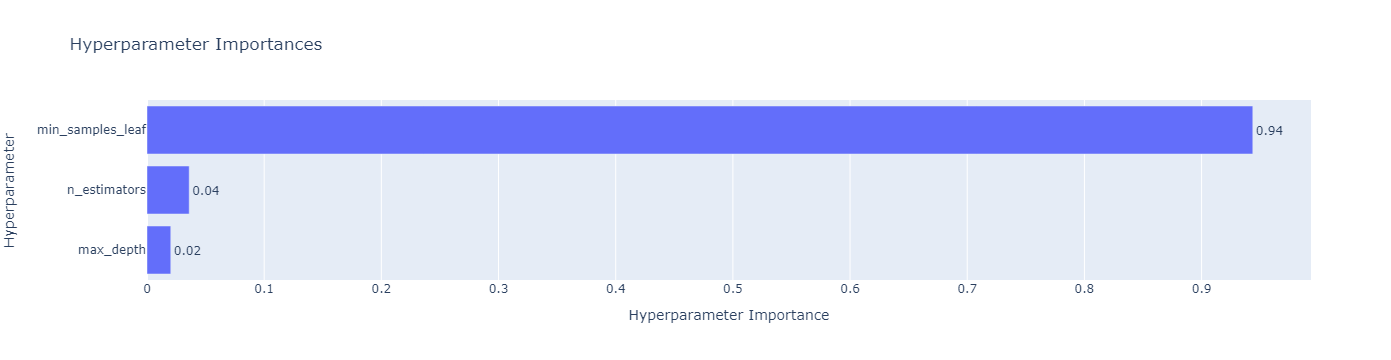

In [65]:
# посмотрим на значимость подбираемых гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="roc_auc")

In [ ]:
# поскольку наиболее значимо минимальное число объектов в листьях, повторим поиск по этому парамеру, зафиксив остальное
def objective(trial):
    # создаем модель
    model = RandomForestClassifier(min_samples_leaf=trial.suggest_int('min_samples_leaf', 5, 20, step = 1),
                                          n_estimators = 330, 
                                          max_depth = 38, 
                                          random_state=42,
                                          n_jobs=-1
                                          )
    score = cross_val_score(model, X_rf, y_rf, cv = 5, scoring="roc_auc", n_jobs = -1).mean()  
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [68]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("roc_auc_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'min_samples_leaf': 9}
roc_auc_score на обучающем наборе: 0.75


In [69]:
# для итоговой оценки возьмем средние предсказания моделей на разных random_state
cat_cols_rf = ['First_deal_date_year','First_deal_date_month','First_deal_date_day','First_default_date_year','First_default_date_month','First_default_date_day','Gender','Region']
df = pd.read_csv('train.csv')
y = df.Default
df_test = pd.read_csv('test.csv')
df.drop(columns = 'Default', inplace = True)

df_full = pd.concat([df, df_test])
df_full = pipe.fit_transform(df_full)
for col in cat_cols_rf:
    df_full[col] = df_full[col].map(str)
df_full = pd.get_dummies(df_full, drop_first = True)

X = df_full[:3168]   # 3168
X_test = df_full[3168:]     # 989
y_pred = np.zeros(X_test.shape[0])  #989

kFold_random_state = [101, 42, 666, 228, 777, 2021, 75]
for random_state in kFold_random_state:
    clf = RandomForestClassifier(max_depth=38, min_samples_leaf=9, n_estimators=330, random_state=random_state)
    clf.fit(X, y)
    y_pred += clf.predict_proba(X_test)[:, 1]
y_pred /= X_test.shape[0]

res = pd.DataFrame()
res['Deal_id'] = df_test.Deal_id
res['Prediction'] = pd.Series(y_pred)
res.to_csv('clf_best_last.csv', index = False)

**ROC_AUC на тесте 0.705**